In [1]:
import os 
import matplotlib.pyplot as plt
import torchaudio
import torch
import IPython
from torchaudio.transforms import MelSpectrogram

In [2]:
torchaudio.list_audio_backends()
# ['ffmpeg', 'soundfile']
# Domanda: cambia qualcosa in base al backend usato?
# E' un problema che quello che viene selezionato per il loading and il saving non è los tesso?

# Based on this information it will use ffmpeg: https://pytorch.org/audio/stable/torchaudio.html

['ffmpeg', 'soundfile']

In [3]:
def plot_figure(data, filename=None):
    # Plot Mel Spectrogram

    plt.figure(figsize=(8, 4))  
    # take the first audio of each frame
    plt.imshow(data, cmap='viridis', aspect='auto', origin='lower')
    plt.colorbar()
    plt.title('Mel Spectrogram')
    plt.xlabel('Time')
    plt.ylabel('Mel Frequency')
    #plt.savefig(os.path.join(f'./img/{filename}'))
    #plt.close()

In [4]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")

In [5]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)

In [6]:
def log_mels(mels, device=None):
    """ Apply the log transformation to mel spectrograms.
    Args:
        mels: torch.Tensor, mel spectrograms for which to apply log.

    Returns:
        Tensor: logarithmic mel spectrogram of the mel spectrogram given as input
    """    
    log_offset=0.001 # Avoids NaNs
    log_output = torch.log(mels +log_offset) 
    
    return log_output

In [7]:
def pad_to(signal, num_samples):
    
    length_signal = signal.shape[1]
    
    # cut if necessary
    if length_signal > num_samples:
        signal = signal[:, :num_samples]
        
    # pad if necessary
    if signal.shape[1] < num_samples:
        num_missing_samples = num_samples - length_signal
        last_dim_padding = (0, num_missing_samples)
        
        # Pad signal by replicating it (LUCA)
        padding = 'Francesca'
        if padding == 'Luca':
            N_replicas = int(num_missing_samples/length_signal)+1
            signal_padded = signal.repeat(1,N_replicas+1)
            signal_padded = signal_padded[:,:num_samples]
            signal = signal_padded
        else:
            signal = torch.nn.functional.pad(signal, last_dim_padding)    
    
    return signal   
    
    
def process_audio(audio_sample_path, target_sample_rate, num_samples):
    
    signal, sr = torchaudio.load(audio_sample_path)
    
    if sr != target_sample_rate:
        resampler = torchaudio.transforms.Resample(sr, target_sample_rate)
        signal = resampler(signal)
    
    # make the signal mono if it is not
    if signal.shape[0] > 1:
        signal = torch.mean(signal, dim=0, keepdim=True)
            
    # pad the signal in necessary
    signal = pad_to(signal, num_samples)
    
    return signal

In [8]:
def post_process(signal):
    # log-mel spectogram
    signal = MelSpectrogram(
            sample_rate=44100, 
            n_fft=1024,
            win_length=1024,
            hop_length=1024,
            f_min=0,
            f_max=22050,
            n_mels=128,
    )(signal)

    signal = log_mels(signal)

    # normalization    
    signal = (signal - torch.mean(signal))/torch.var(signal)

    return signal

# Files path to use

In [9]:
# example for dog barking
classes = 'street_music'

if classes == 'dog_bark':
    urban_sound_path = "/nas/home/fronchini/EUSIPCO/urban-sound-class/UrbanSound8K/audio/fold5/100032-3-0-0.wav"
    n_file = 500
elif classes == 'children_playing':
    urban_sound_path = "/nas/home/fronchini/EUSIPCO/urban-sound-class/UrbanSound8K/audio/fold10/101382-2-0-10.wav"
    n_file = 200
elif classes == 'street_music':
    urban_sound_path = "/nas/home/fronchini/EUSIPCO/urban-sound-class/UrbanSound8K/audio/fold7/101848-9-0-3.wav"
    n_file = 350
    
audio_gen_path = "/nas/home/fronchini/EUSIPCO/urban-sound-class/audio_generation/AUDIOGEN_dataset"
audio_ldm_path = "/nas/home/fronchini/EUSIPCO/urban-sound-class/audio_generation/AUDIOLDM2_dataset"


In [10]:
audio_gen_path = os.path.join(audio_gen_path, classes, f"{n_file}.wav.wav")
audio_ldm_path = os.path.join(audio_ldm_path, classes, f"{n_file}.wav")
print(audio_gen_path)
print(audio_ldm_path)

/nas/home/fronchini/EUSIPCO/urban-sound-class/audio_generation/AUDIOGEN_dataset/street_music/350.wav.wav
/nas/home/fronchini/EUSIPCO/urban-sound-class/audio_generation/AUDIOLDM2_dataset/street_music/350.wav


In [11]:
audio_gen_audio = torchaudio.load(audio_gen_path)
audio_ldm_audio = torchaudio.load(audio_ldm_path)
audio_urban = torchaudio.load(urban_sound_path)

# AudioGen

In [12]:
info = torchaudio.info(audio_gen_path)
print(info)

AudioMetaData(sample_rate=16000, num_frames=64000, num_channels=1, bits_per_sample=16, encoding=PCM_S)


torch.float32


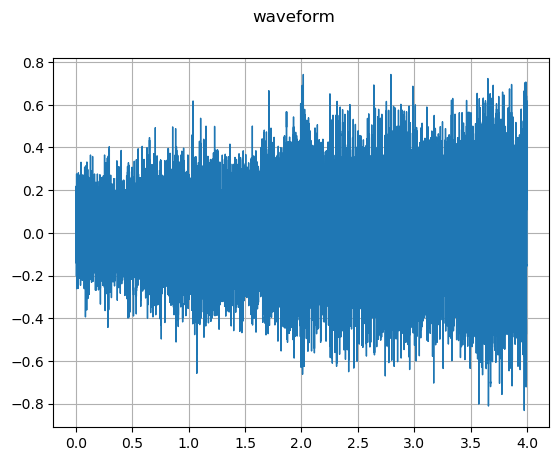

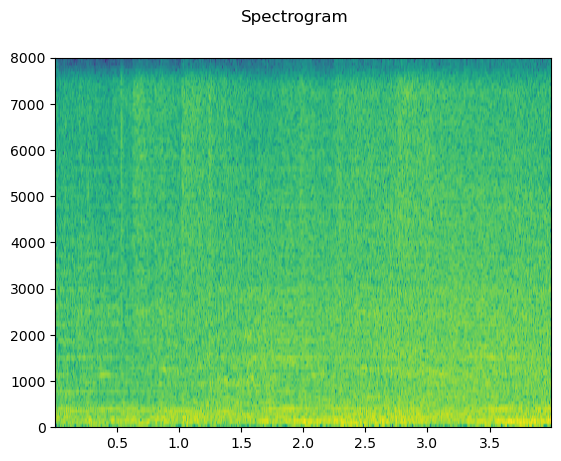

In [13]:
audio_gen_audio
print(audio_gen_audio[0].dtype)
plot_waveform(audio_gen_audio[0], audio_gen_audio[1])
plot_specgram(audio_gen_audio[0], audio_gen_audio[1])

In [14]:
print(f"Min values: {audio_gen_audio[0].min()}")
print(f"Max values: {audio_gen_audio[0].max()}")

Min values: -0.832061767578125
Max values: 0.741455078125


## AudioLDM

In [15]:
info = torchaudio.info(audio_ldm_path)
print(info)

AudioMetaData(sample_rate=16000, num_frames=64000, num_channels=1, bits_per_sample=32, encoding=PCM_F)


torch.float32


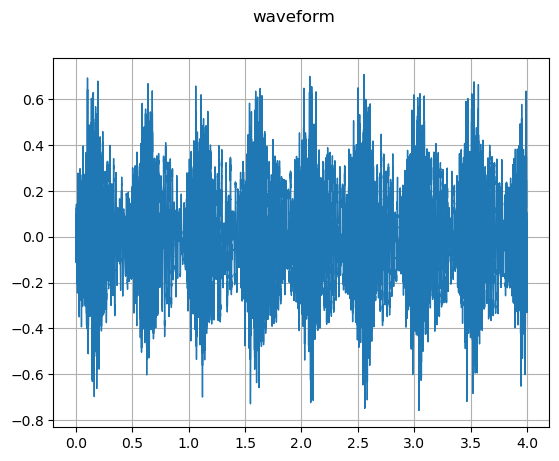

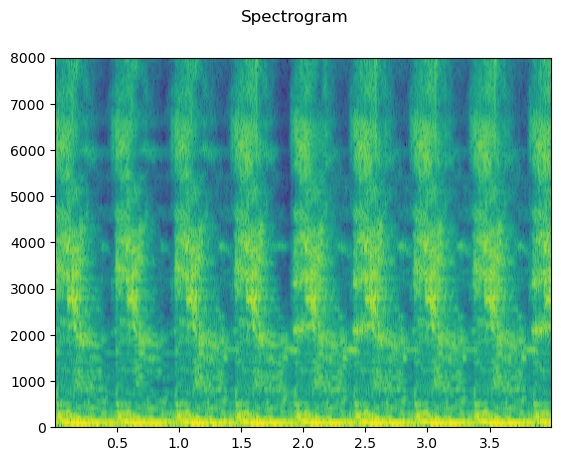

In [16]:
audio_ldm_audio
print(audio_ldm_audio[0].dtype)
plot_waveform(audio_ldm_audio[0], audio_ldm_audio[1])
plot_specgram(audio_ldm_audio[0], audio_ldm_audio[1])

In [17]:
print(f"Min values: {audio_ldm_audio[0].min()}")
print(f"Max values: {audio_ldm_audio[0].max()}")

Min values: -0.75732421875
Max values: 0.70654296875


## Audio Urban

In [18]:
info = torchaudio.info(urban_sound_path)
print(info)

AudioMetaData(sample_rate=44100, num_frames=176400, num_channels=2, bits_per_sample=16, encoding=PCM_S)


torch.float32


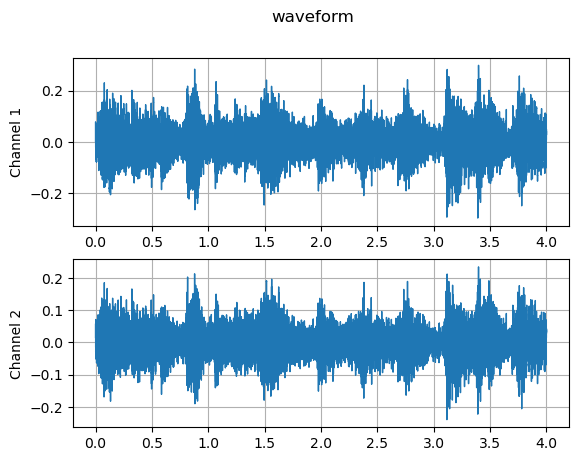

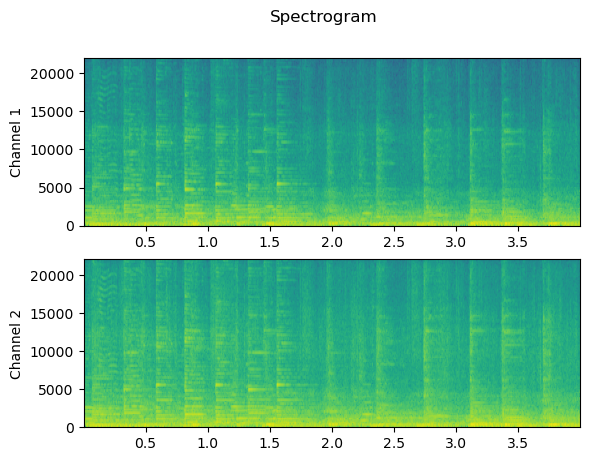

In [19]:
audio_urban
print(audio_urban[0].dtype)
plot_waveform(audio_urban[0], audio_urban[1])
plot_specgram(audio_urban[0], audio_urban[1])

In [20]:
print(f"Min values: {audio_urban[0].min()}")
print(f"Max values: {audio_urban[0].max()}")

Min values: -0.29742431640625
Max values: 0.298583984375


In [21]:
# mi sembra di capire che sono effettivamente tutti noormalizzati tra -1 ed 1 tutti float32, giusto?
# dovrebbe tutto essere gestito internamente, giusto?

# Processing the audio the same way it is processed by the code of the network. 

## AudioGen

In [22]:
target_sr = 41000
num_sample = 44100 * 4

In [23]:
IPython.display.Audio(audio_gen_audio[0], rate=audio_gen_audio[1])

/nas/home/fronchini/miniconda3/envs/tagging/lib/python3.8/site-packages/matplotlib/axes/_axes.py:7774: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


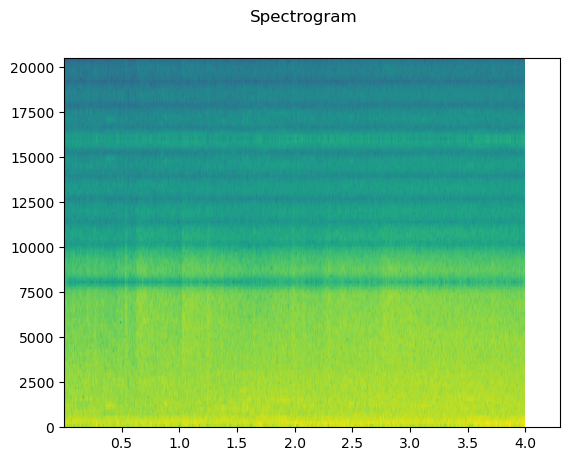

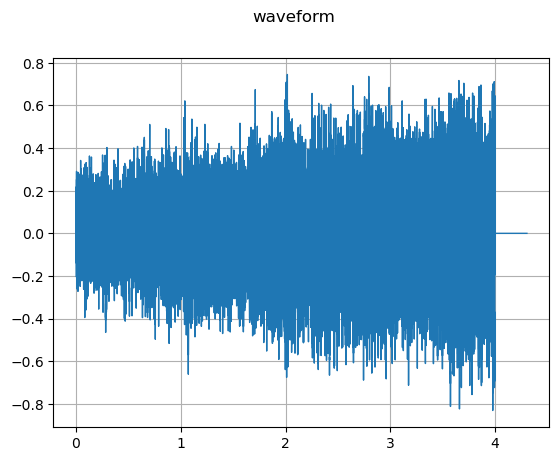

In [24]:
signal = process_audio(audio_gen_path, target_sample_rate=target_sr, num_samples=num_sample)
plot_specgram(signal, target_sr)
plot_waveform(signal, target_sr)



In [25]:
signal = post_process(signal)

/nas/home/fronchini/miniconda3/envs/tagging/lib/python3.8/site-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (513) may be set too low.
  warnings.warn(


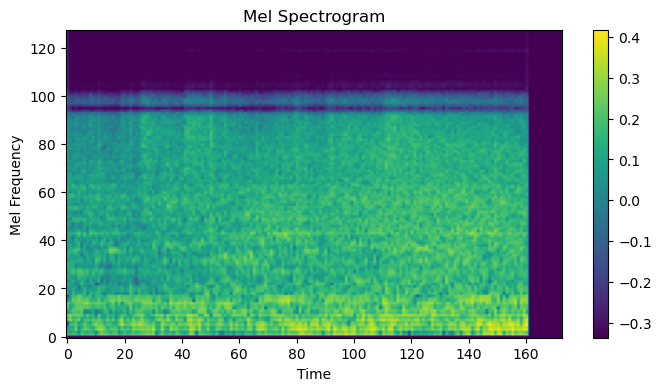

In [26]:
plot_figure(signal[0])

## AudioLDM

In [27]:
IPython.display.Audio(audio_ldm_audio[0], rate=audio_ldm_audio[1])

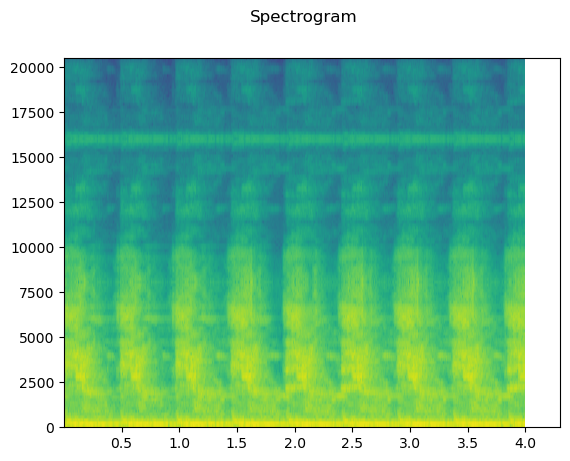

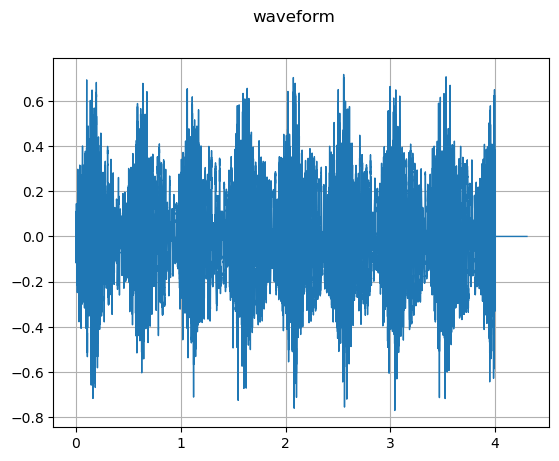

In [28]:
signal = process_audio(audio_ldm_path, target_sample_rate=target_sr, num_samples=num_sample)
plot_specgram(signal, target_sr)
plot_waveform(signal, target_sr)

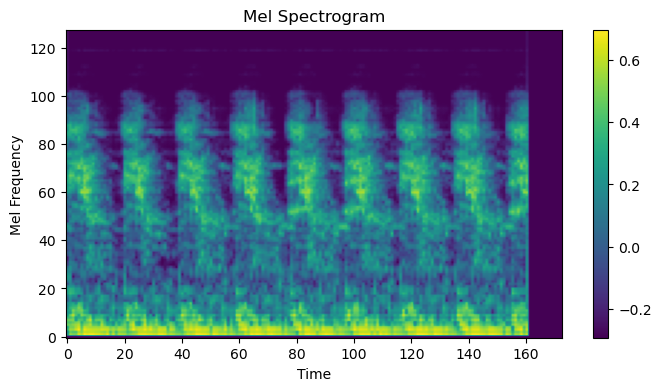

In [29]:
signal = post_process(signal)
plot_figure(signal[0])

## Urban Audio

In [30]:
IPython.display.Audio(audio_urban[0], rate=audio_urban[1])

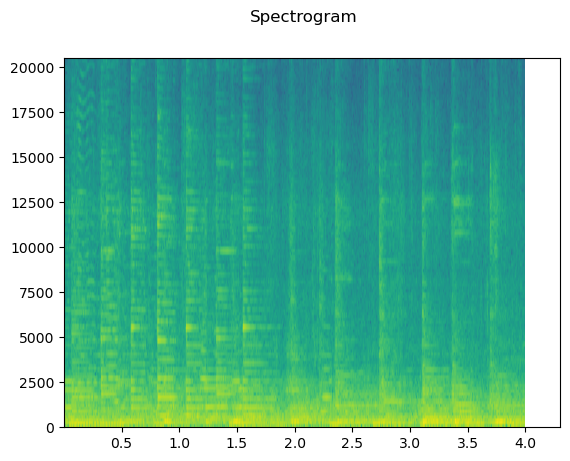

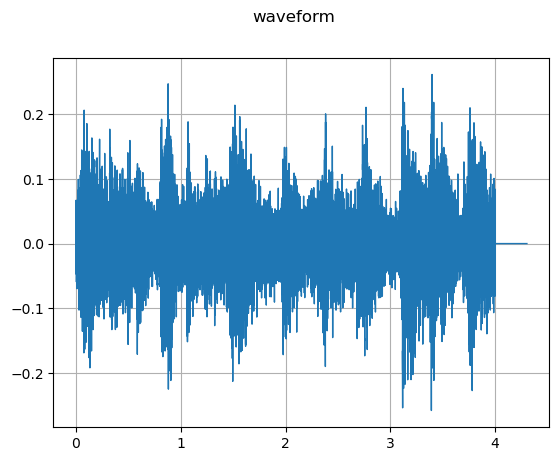

In [31]:
signal = process_audio(urban_sound_path, target_sample_rate=target_sr, num_samples=num_sample)
plot_specgram(signal, target_sr)
plot_waveform(signal, target_sr)

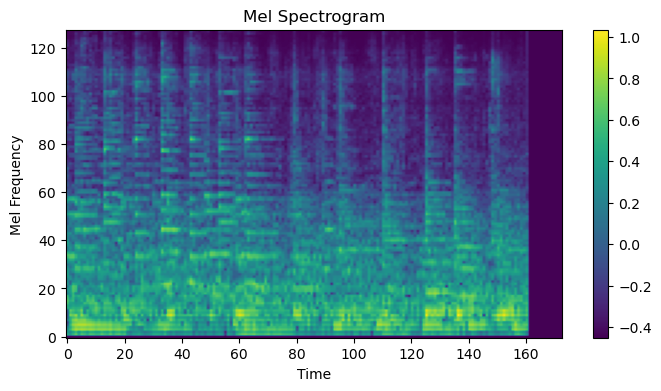

In [32]:
signal = post_process(signal)
plot_figure(signal[0])